In [1]:
from tqdm.notebook import tqdm
import os
from glob import glob
import json
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union

import albumentations as A
from multiprocessing.pool import ThreadPool
import cv2
import numpy as np
import torch
from torch import nn 
from torchvision.ops import DeformConv2d 
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

import pycocotools.coco as coco
from pycocotools.cocoeval import COCOeval

In [2]:
base = 'data/F0'
Images = os.path.join(base, 'Images', '1/*.tiff') 
Poses = os.path.join(base, 'Poses', '1.json')

In [8]:
images = [os.path.basename(fn) for fn in sorted(glob(Images))]
poses = json.load(open(Poses, 'rb'))['images']

images_with_pose = []
for pose in poses:  # pose is a dictionary
    images_with_pose.append(pose['imagefile'])

images_with_pose = sorted(images_with_pose)

In [12]:
# all images are annotated with a pose! (F0 lane 1)
images = np.asarray(images)
images_with_pose = np.asarray(images_with_pose)
(images == images_with_pose).all()

True

In [21]:
def poses_info(folder_paths: List[str]):
    for folder_path in folder_paths:
        for image_folder in glob(os.path.join(folder_path, 'Images', '*')):
            folder_nr = image_folder.split('\\')[-1]
            
            Images = os.path.join(image_folder, '*.tiff')
            images = [os.path.basename(fn) for fn in sorted(glob(Images))] 
            
            Poses = os.path.join(folder_path, 'Poses', f'{folder_nr}.json')
            poses = json.load(open(Poses, 'rb'))['images']

            images_with_pose = []
            for pose in poses:  # pose is a dictionary
                images_with_pose.append(pose['imagefile'])
            
            images_with_pose = sorted(images_with_pose)
            images = np.asarray(images)
            images_with_pose = np.asarray(images_with_pose)
            if (images == images_with_pose).all():
                # all images have a pose
                print('passed at:', image_folder)
            else:
                print('failed at:', image_folder)


poses_info([f'data/F{i}' for i in range(12)])

passed at: data/F0\Images\1
passed at: data/F0\Images\10
passed at: data/F0\Images\11
passed at: data/F0\Images\12
passed at: data/F0\Images\13
passed at: data/F0\Images\2
passed at: data/F0\Images\3
passed at: data/F0\Images\4
passed at: data/F0\Images\5
passed at: data/F0\Images\6
passed at: data/F0\Images\7
passed at: data/F0\Images\8
passed at: data/F0\Images\9
passed at: data/F1\Images\1
passed at: data/F1\Images\2
passed at: data/F1\Images\3
passed at: data/F1\Images\4
passed at: data/F1\Images\5
passed at: data/F1\Images\6
passed at: data/F2\Images\1
passed at: data/F2\Images\2
passed at: data/F2\Images\3
passed at: data/F2\Images\4
passed at: data/F2\Images\5
passed at: data/F2\Images\6
passed at: data/F2\Images\7
passed at: data/F2\Images\8
passed at: data/F3\Images\1
passed at: data/F3\Images\10
passed at: data/F3\Images\11
passed at: data/F3\Images\12
passed at: data/F3\Images\2
passed at: data/F3\Images\3
passed at: data/F3\Images\4
passed at: data/F3\Images\5
passed at: da

In [32]:
def extract_data(folder_paths: List[str]): 
    data = {}
    nr = 0  # unique lane number, can be used to shuffle in training
    for folder_path in folder_paths:
        pose_files = sorted(glob(os.path.join(folder_path, 'Poses', '*.json')))
        label_files = sorted(glob(os.path.join(folder_path, 'Labels', '*.json')))
        for pose_file, label_file in zip(pose_files, label_files):
            data[nr] = {} 
            poses = json.load(open(pose_file, 'rb'))['images']
            labels = json.load(open(label_file, 'rb'))['Labels']
            
            images_with_poses = []
            polys = []
            for pose in poses:
                images_with_poses.append((pose['imagefile'], pose['M3x4']))

            if isinstance(labels, list) and len(labels):  
                for label in labels:
                    polys.append(label['poly'])
                # for each lane we have a single annotated image (for the integral image)
                data[nr]['annotated_image'] = labels[0]['imagefile']
                # polygons: [ [[x1, y1], ...next point], ...next polygon ]
                data[nr]['polys'] = polys
            else:  # otherwise empty => no annotations (no humans)
                data[nr]['annotated_image'] = data[nr]['polys'] = None

            # we have the camera extrinsics for each image in the lane
            data[nr]['images_with_poses'] = images_with_poses
            nr += 1
            
    return data


# training folder names are from F0 to F11
data = extract_data([f'data/F{i}' for i in range(12)])

In [2]:
class Baseset(Dataset):

    def __init__(self, folders: List[str], h: int, w: int, cache=False,
        transform=None):
        super().__init__()
        self.folders = folders  # e.g. ['data/F0', ...]
        self.h = h  # image height
        self.w = w  # image width
        self.cache = cache  # store images as path string or np.ndarray 
        self.transform = transform
        
        self.data = self.extract_data(folders)
        self.size = len(self.data)
        if cache:
            self.cache_images()

    def cache_images(self): 
        results = ThreadPool(4).imap(self.imread, (lane['images'] for lane in self.data))
        pbar = tqdm(enumerate(results), total=self.size)
        gb = 0
        for lane_nr, lane_images in pbar:
            self.data[lane_nr]['images'] = lane_images  
            gb += lane_images.nbytes
            pbar.desc = f'Caching images ({gb/1E9:.1f}GB)'

    @staticmethod
    def extract_data(folders: List[str]):
        '''
        extract the relevant information from the folder structure and 
        cluster it lane-wise:

        [{'images': [('.../some_name.tiff', ...], 
          'poses': [pose_M3x4, ...],
          'annotated_image': '.../some_name.tiff', 
          'polys': [[...]], }, 
         {...}, ...]
        
        note: for each image there exists a pose, per lane there are bbox 
        annotations for a single image (bboxes make sense after integration)
        ''' 
        data = []  # each lane is a element (dictionary) in the 'data' list
        for folder_path in folders:
            pose_files = sorted(glob(os.path.join(folder_path, 'Poses', '*.json')))
            label_files = sorted(glob(os.path.join(folder_path, 'Labels', '*.json')))
            for pose_file, label_file in zip(pose_files, label_files):
                lane = {}
                poses = json.load(open(pose_file, 'rb'))['images']
                labels = json.load(open(label_file, 'rb'))['Labels']
                lane_nr = os.path.splitext(os.path.basename(pose_file))[0]
                base_path = os.path.join(folder_path, 'Images', lane_nr)

                image_paths = []
                pose_matrices = []
                for pose in poses:
                    image_paths.append(os.path.join(base_path, pose['imagefile']))
                    pose_matrices.append(np.asarray(pose['M3x4']))

                polys = []
                if isinstance(labels, list) and len(labels):  
                    for label in labels:
                        polys.append(label['poly'])
                    # each lane has a single annotated image (the integral image)
                    lane['annotated_image'] = os.path.join(base_path, 
                        labels[0]['imagefile'])  # full path
                    # polygons: [ [[x1, y1], ...next point], ...next polygon ]
                    lane['polys'] = polys
                else:  # otherwise empty => no annotations (no humans)
                    lane['annotated_image'] = lane['polys'] = None

                # we have the camera extrinsics for each image in the lane
                lane['images'] = image_paths
                lane['poses'] = pose_matrices

                data.append(lane)  # each pose and label file correspondes to a lane
                
        return data

    @staticmethod
    def show_images(images: np.ndarray, mask: np.ndarray = None, figsize=None):
        fig = plt.figure(figsize=figsize)
        if mask is not None:  # k,
            images = images[mask, ...]  # k x h x w
        images = torch.as_tensor(images).unsqueeze(1)  # n(k) x 1 x h x w
        grid = make_grid(images, nrow=int(np.sqrt(images.size(0))))  # 3 x h x w
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

    @staticmethod
    def show_image(image: np.ndarray, cmap: str = 'gray', figsize=None):
        fig = plt.figure(figsize=figsize)
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
        plt.show()

    @staticmethod
    def load_camera_params(param_folder: str = 'calibration/parameters'):
        ''' Camera intrinsics K and distortion coefficients. '''
        K = np.load(os.path.join(param_folder, 'K.npy'))
        dist_coeffs = np.load(os.path.join(param_folder, 'dist_coeffs.npy'))
        return K, dist_coeffs

    @staticmethod
    def imread(paths: List[str], K=None, dist_coeffs=None) -> np.ndarray:
        images = []
        for path in paths:
            image = cv2.imread(path, cv2.IMREAD_ANYDEPTH)  # 16 bit image
            image = cv2.normalize(image, dst=None, alpha=0, beta=2**16 - 1, 
                norm_type=cv2.NORM_MINMAX)
            image = (image >> 8).astype(np.uint8)  # 8 bit image
            
            if K is not None and dist_coeffs is not None:  # undistort images
                h, w = image.shape
                # new camera intrinsics based on free scaling parameter
                refined_K, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, 
                    (w, h), 1, (w, h))
                x, y, w, h = roi
                image = image[y:y+h, x:x+w]
                image = cv2.undistort(image, K, dist_coeffs, None, refined_K)
            
            images.append(image)

        return np.asarray(images)  # n_paths x h x w

    @staticmethod
    def integrate(images: Union[List[str], np.ndarray], pose_matrices: List[np.ndarray], 
        K: np.ndarray, z: float = 30.0, verbose=False) -> Tuple[np.ndarray, np.ndarray]:
        '''
        integral :=
        a mapping of a image sequence under perspective to another image view

        images contains the image file paths or the np.ndarray images and pose_matrices 
        the M3x4 matrices where M3x4 = (R3x3, t3x1) => thus without intrinsics K

        z is the height of the camera (drone) in meters

        note: must be a odd sequence length
        '''
        sequence_len = len(images)
        idc = sequence_len // 2  # id of center image
        
        if isinstance(images, list):
            images = Baseset.imread(images)  # 8 bit images
        
        h, w = images.shape[1:]  # gray scale images
        integral = np.zeros((h, w), np.float64)
        
        # inverse of the intrinsic mapping
        K_inv = np.linalg.inv(K)

        Mc = pose_matrices[idc]
        Rc = Mc[:, :3]  # 3 x 3
        tc = Mc[:, 3:]  # 3 x 1

        for idx in range(sequence_len):
            if idx != idc:
                Mr = pose_matrices[idx]  # 3 x 4
                Rr = Mr[:, :3]  # 3 x 3
                tr = Mr[:, 3:]  # 3 x 1

                # relative translation and rotation
                R_rel = Rc @ Rr.T  # 3 x 3
                t_rel = tc - R_rel @ tr  # 3 x 1

                B = K @ R_rel @ K_inv
                B[:, 2:] += K @ t_rel / z
                warped = cv2.warpPerspective(images[idx], B, (w, h))

                if verbose:
                    Baseset.show_image(warped)

                integral += warped
            else:
                if verbose:
                    Baseset.show_image(images[idx])

                integral += images[idx]

        integral /= sequence_len
        # 8 bit gray scale integral image
        integral = cv2.normalize(integral, None, 
            0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # returns (image sequence, integral image)
        return images, integral  

    def __len__(self):
        return self.size

    def _float(self, x: float):
        return float(f'{x:0.2f}')


class IntegralDataset(Baseset):
    ''' For training and testing of the deep learning based integration. '''

    def __init__(self, folders: List[str], h: int, w: int, sequence_len=5,
        cache=False, transform=None):
        super().__init__(folders, h, w, cache, transform)
        self.sequence_len = sequence_len
        self.K, _ = self.load_camera_params()

    def __getitem__(self, idx):
        lane = self.data[idx]  # select lane

        # randomly select adjacent images and correspondig poses
        start = np.random.randint(len(lane['images']) - self.sequence_len)
        images = lane['images'][start:start + self.sequence_len]
        pose_matrices = lane['poses'][start:start + self.sequence_len]
        image_sequence, integral_image = self.integrate(images, pose_matrices, self.K)

        if self.transform is not None:
            # data augmentation on images
            image_sequence, integral_image = self.transform(image_sequence, integral_image)
        
        return image_sequence, integral_image


class DetectionTrainset(Baseset):
    ''' For training of the deep learning based detection. '''

    def __init__(self, folders: List[str], h: int, w: int, cache=False,
        transform=None):
        super().__init__(folders, h, w, cache, transform)

    def __getitem__(self, idx):
        return None


class DetectionTestset(Baseset):
    ''' For testing of the deep learning based detection. '''

    def __init__(self, folders: List[str], h: int, w: int, cache=False,
        transform=None):
        super().__init__(folders, h, w, cache, transform)

    def __getitem__(self, idx):
        return None

In [44]:
img = Baseset.imread(['data/F0/Images/1/20191004_091801.tiff'])
img.shape

(1, 512, 640)

In [3]:
# test the implementation of the integration dataset:
folders = [f'data/F{i}' for i in range(12)]
h, w = 512, 640
ids = IntegralDataset(folders, h, w, sequence_len=5, cache=True, transform=None)

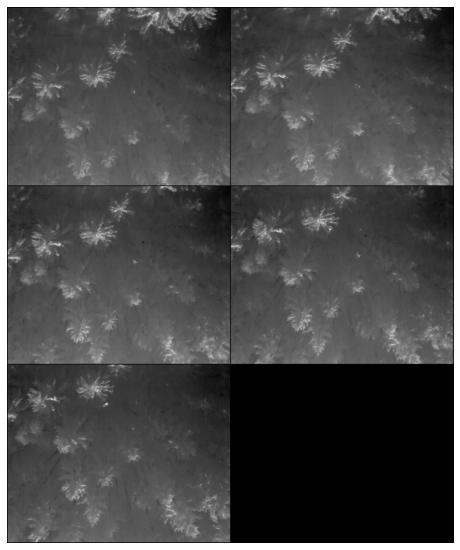

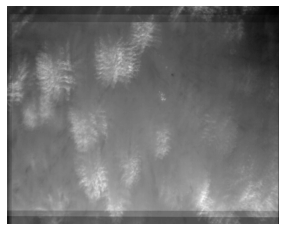

In [4]:
image_sequence, integral_image = ids[0]
ids.show_images(image_sequence, figsize=(8, 10))
ids.show_image(integral_image)

In [7]:
idl = DataLoader(ids, shuffle=True, num_workers=0, batch_size=10, drop_last=True)
batch = next(iter(idl))  # inspect a single mini batch

In [8]:
batch[0].shape  # image sequences of length 5

torch.Size([10, 5, 512, 640])

In [9]:
batch[1].shape  # the 10 integral image targets

torch.Size([10, 512, 640])

In [76]:
# TODO: integration is not perfect yet, seams blurry and not overlapping exactly
# may caused by distortion? how should those images look like? compare to matlab
# version of integration!

In [ ]:
def autopad(k, p=None):  # kernel, padding
    if p is None:  # add padding to keep spatial dimensions
        # kernel can be scalar or tuple
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p


class Conv(nn.Module):
    def __init__(self, chi, cho, k: int = 1, s: int = 1, 
        p=None, g=1, act: nn.Module = nn.ReLU(), deformable=False):  
        super().__init__()
        if deformable:
            self.conv = DeformConv2d(chi, cho, k, s, autopad(k, p), groups=g, bias=False)
        else:
            self.conv = nn.Conv2d(chi, cho, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm2d(cho)
        self.act = act

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def fuseforward(self, x):
        return self.act(self.conv(x))


class Bottleneck(nn.Module):
    def __init__(self, chi, cho, shortcut=True, g=1, e=0.5):  
        super().__init__()
        chh = int(cho * e)
        self.cv1 = Conv(chi, chh, 1, 1)
        self.cv2 = Conv(chh, cho, 3, 1, g=g)
        self.add = shortcut and chi == cho

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class BottleneckCSP(nn.Module):
    
    def __init__(self, chi, cho, n=1, shortcut=True, g=1, e=0.5):
        super().__init__()
        chh = int(cho * e)  
        self.cv1 = Conv(chi, chh, 1, 1)
        self.cv2 = nn.Conv2d(chi, chh, 1, 1, bias=False)
        self.cv3 = nn.Conv2d(chh, chh, 1, 1, bias=False)
        self.cv4 = Conv(2 * chh, cho, 1, 1)
        self.bn = nn.BatchNorm2d(2 * chh)  # applied to cat(cv2, cv3)
        self.act = nn.LeakyReLU(0.1, inplace=True)
        self.m = nn.Sequential(*[Bottleneck(chh, chh, shortcut, g, e=1.0) for _ in range(n)])

    def forward(self, x):
        y1 = self.cv3(self.m(self.cv1(x)))
        y2 = self.cv2(x)
        return self.cv4(self.act(self.bn(torch.cat((y1, y2), dim=1))))

class IntegralNet_v1(nn.Module):

    def __init__(self, chi):
